#### Cargamos los csv de cada resultado del entrenamiento de 200 épocas

In [2]:
# Recorremos los directoriso de ntro de resultados _200_epoc
from pathlib import Path
import pandas as pd

# Ruta a la carpeta principal
ruta_principal = Path('./resultados_200_epoc/')

resultados = {}

# Recorrer los subdirectorios
for subdirectorio in ruta_principal.iterdir():
    if subdirectorio.is_dir():
        res_csv = subdirectorio / 'results.csv'
        if res_csv.exists():
            name = subdirectorio.name
            name = name.split('_')[0]
            print(f"Procesando {name}")
            resultados[name] = pd.read_csv(res_csv)

Procesando yolo9n
Procesando yolo8n
Procesando yolov11n


### Vemos la duración de los entrenamientos en épocas y en tiempo

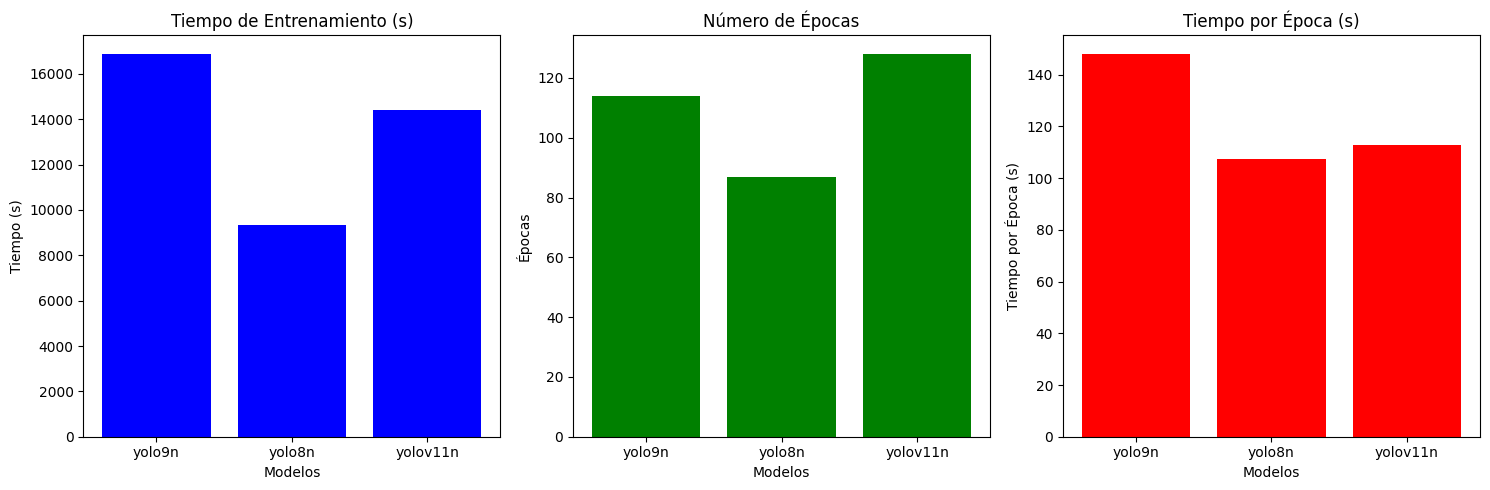

In [3]:
import matplotlib.pyplot as plt

# Comparación de numero de épocas entrenadas y duración del entrenamiento

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

modelos = list(resultados.keys())
tiempos = [resultados[modelo]['time'].iloc[-1] for modelo in modelos]
epocas = [len(resultados[modelo]['epoch']) - 1 for modelo in modelos]

ratios = [t/e for t, e in zip(tiempos, epocas)]

# Gráfico de tiempo de entrenamiento
axs[0].bar(modelos, tiempos, color='blue')
axs[0].set_title('Tiempo de Entrenamiento (s)')
axs[0].set_xlabel('Modelos')
axs[0].set_ylabel('Tiempo (s)')

# Gráfico de número de épocas
axs[1].bar(modelos, epocas, color='green')
axs[1].set_title('Número de Épocas')
axs[1].set_xlabel('Modelos')
axs[1].set_ylabel('Épocas')

# Tiempo invertido en cada época
axs[2].bar(modelos, ratios, color='red')
axs[2].set_title('Tiempo por Época (s)')
axs[2].set_xlabel('Modelos')
axs[2].set_ylabel('Tiempo por Época (s)')


plt.tight_layout()
plt.show()


#### Cada vez que el modelo produce una mejora en la mAP50-95 en el conjunto de validación, se guarda automáticamente como best.pt.  

Vamos a coger los datos de la época con mejor mAP

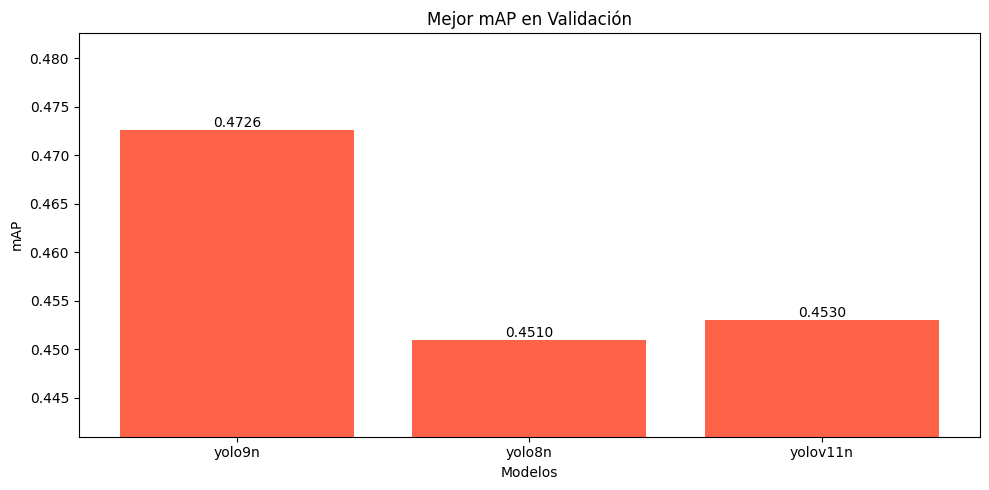

In [33]:
# Mejores mAP en validación por modelo

fig, ax = plt.subplots(figsize=(10, 5))

mAPs = [resultados[modelo]['metrics/mAP50-95(B)'].max() for modelo in modelos]

bars = ax.bar(modelos, mAPs, color='tomato')
ax.set_title('Mejor mAP en Validación')
ax.set_xlabel('Modelos')
ax.set_ylabel('mAP')
ax.set_ylim(min(mAPs) - 0.01, max(mAPs) + 0.01)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [36]:
# Extraemos la informción de cada fila de cada modelo usando la mAP máxima de validación como indice

# Paso 1: Iterar sobre los modelos y obtener el DataFrame correspondiente
filas_max_mAP = []
for modelo in modelos:
    df_modelo = resultados[modelo]
    
    # Paso 2: Encontrar el índice del valor máximo
    idx_max = df_modelo['metrics/mAP50-95(B)'].idxmax()
    
    # Paso 3: Seleccionar la fila con el valor máximo
    fila_max = df_modelo.loc[idx_max]
    
    # Agregar la fila a la lista
    filas_max_mAP.append(fila_max)

# Paso 4: Concatenar las filas en un DataFrame
df_concatenado = pd.concat(filas_max_mAP, axis=1, keys=modelos)
# Paso 5: Transponer el DataFrame
mejores_resultados = df_concatenado.T
# Convertir en diccionario
mejores_resultados_dict = mejores_resultados.to_dict(orient='index')


### Resultados de las losses con los mejores resultados

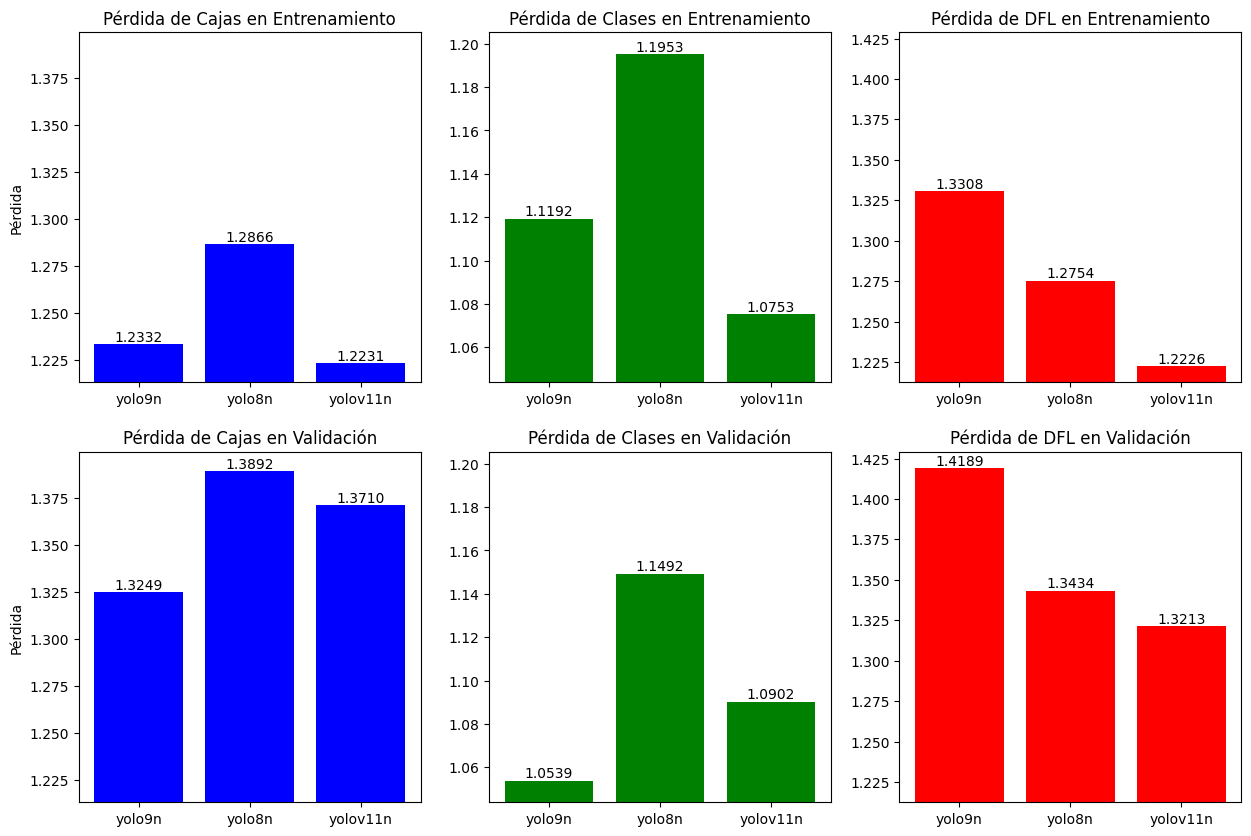

In [46]:
train_loss = ['train/box_loss', 'train/cls_loss', 'train/dfl_loss']
val_loss = ['val/box_loss', 'val/cls_loss', 'val/dfl_loss']

t_boxLoss = [mejores_resultados_dict[modelo][train_loss[0]] for modelo in modelos]
t_clsLoss = [mejores_resultados_dict[modelo][train_loss[1]] for modelo in modelos]
t_dflLoss = [mejores_resultados_dict[modelo][train_loss[2]] for modelo in modelos]

v_boxLoss = [mejores_resultados_dict[modelo][val_loss[0]] for modelo in modelos]
v_clsLoss = [mejores_resultados_dict[modelo][val_loss[1]] for modelo in modelos]
v_dflLoss = [mejores_resultados_dict[modelo][val_loss[2]] for modelo in modelos]

limites_box = (min(t_boxLoss + v_boxLoss) -0.01, max(t_boxLoss + v_boxLoss) + 0.01)
limites_cls = (min(t_clsLoss + v_clsLoss) - 0.01, max(t_clsLoss + v_clsLoss) + 0.01)
limites_dfl = (min(t_dflLoss + v_dflLoss) - 0.01, max(t_dflLoss + v_dflLoss) + 0.01)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Gráfico de pérdida de cajas en entrenamiento
bars = axs[0, 0].bar(modelos, t_boxLoss, color='blue')
axs[0, 0].set_title('Pérdida de Cajas en Entrenamiento')
axs[0, 0].set_ylabel('Pérdida')
axs[0, 0].set_ylim(limites_box)
for bar in bars:
    yval = bar.get_height()
    axs[0, 0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

# Gráfico de pérdida de clases en entrenamiento
bars = axs[0, 1].bar(modelos, t_clsLoss, color='green')
axs[0, 1].set_title('Pérdida de Clases en Entrenamiento')
axs[0, 1].set_ylim(limites_cls)
for bar in bars:
    yval = bar.get_height()
    axs[0, 1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

# Gráfico de pérdida de DFL en entrenamiento
bars = axs[0, 2].bar(modelos, t_dflLoss, color='red')
axs[0, 2].set_title('Pérdida de DFL en Entrenamiento')
axs[0, 2].set_ylim(limites_dfl)
for bar in bars:
    yval = bar.get_height()
    axs[0, 2].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

# Gráfico de pérdida de cajas en validación
bars = axs[1, 0].bar(modelos, v_boxLoss, color='blue')
axs[1, 0].set_title('Pérdida de Cajas en Validación')
axs[1, 0].set_ylabel('Pérdida')
axs[1, 0].set_ylim(limites_box)
for bar in bars:
    yval = bar.get_height()
    axs[1, 0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

# Gráfico de pérdida de clases en validación
bars = axs[1, 1].bar(modelos, v_clsLoss, color='green')
axs[1, 1].set_title('Pérdida de Clases en Validación')
axs[1, 1].set_ylim(limites_cls)
for bar in bars:
    yval = bar.get_height()
    axs[1, 1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

# Gráfico de pérdida de DFL en validación
bars = axs[1, 2].bar(modelos, v_dflLoss, color='red')
axs[1, 2].set_title('Pérdida de DFL en Validación')
axs[1, 2].set_ylim(limites_dfl)
for bar in bars:
    yval = bar.get_height()
    axs[1, 2].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.show()


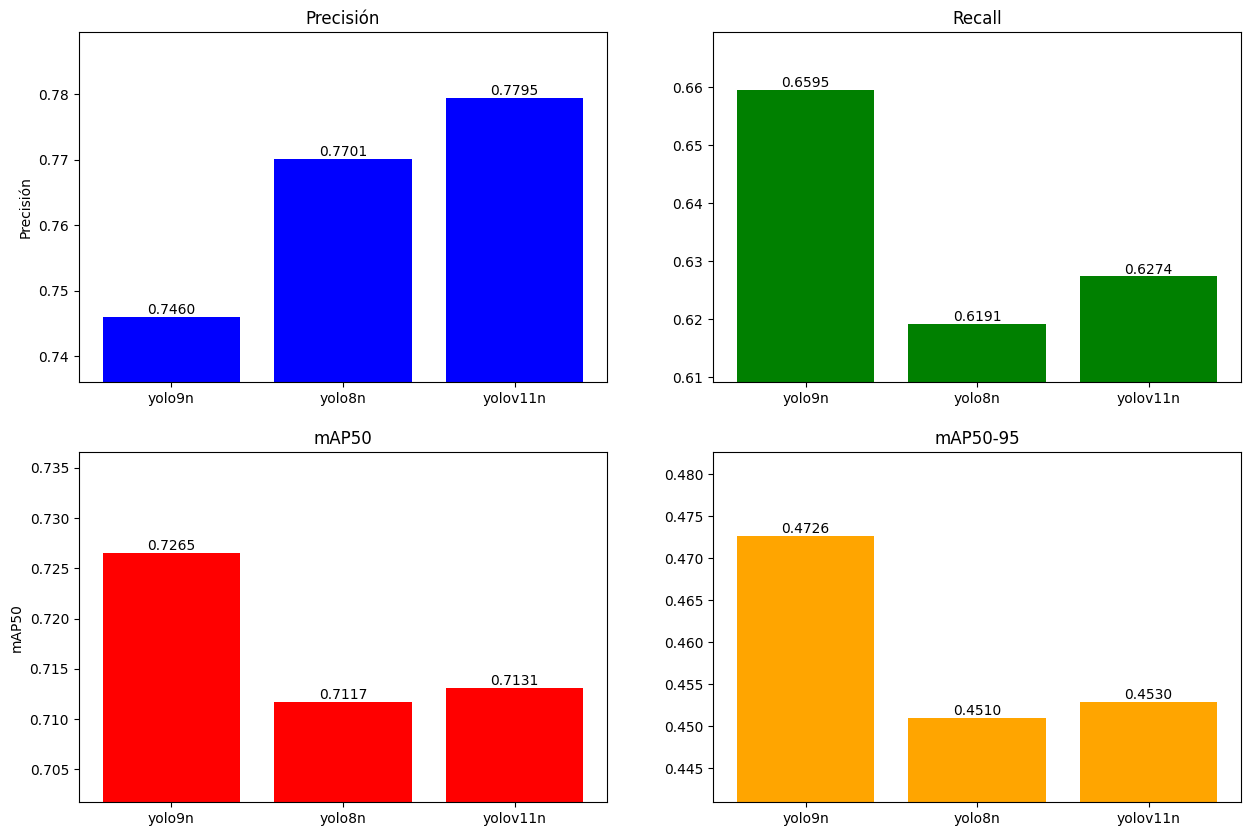

In [50]:
metrics = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

precision = [mejores_resultados_dict[modelo][metrics[0]] for modelo in modelos]
recall = [mejores_resultados_dict[modelo][metrics[1]] for modelo in modelos]
mAP50 = [mejores_resultados_dict[modelo][metrics[2]] for modelo in modelos]
mAP50_95 = [mejores_resultados_dict[modelo][metrics[3]] for modelo in modelos]

limites_precision = (min(precision) - 0.01, max(precision) + 0.01)
limites_recall = (min(recall) - 0.01, max(recall) + 0.01)
limites_mAP50 = (min(mAP50) - 0.01, max(mAP50) + 0.01)
limites_mAP50_95 = (min(mAP50_95) - 0.01, max(mAP50_95) + 0.01)

fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Gráfico de precisión
bars = axs[0, 0].bar(modelos, precision, color='blue')
axs[0, 0].set_title('Precisión')
axs[0, 0].set_ylabel('Precisión')
axs[0, 0].set_ylim(limites_precision)
for bar in bars:
    yval = bar.get_height()
    axs[0, 0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

# Gráfico de recall
bars = axs[0, 1].bar(modelos, recall, color='green')
axs[0, 1].set_title('Recall')
axs[0, 1].set_ylim(limites_recall)
for bar in bars:
    yval = bar.get_height()
    axs[0, 1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

# Gráfico de mAP50
bars = axs[1, 0].bar(modelos, mAP50, color='red')
axs[1, 0].set_title('mAP50')
axs[1, 0].set_ylabel('mAP50')
axs[1, 0].set_ylim(limites_mAP50)
for bar in bars:
    yval = bar.get_height()
    axs[1, 0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

# Gráfico de mAP50-95
bars = axs[1, 1].bar(modelos, mAP50_95, color='orange')
axs[1, 1].set_title('mAP50-95')
axs[1, 1].set_ylim(limites_mAP50_95)
for bar in bars:
    yval = bar.get_height()
    axs[1, 1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.show()

### Comprobar con los datos de test

In [52]:
# Recorremos los directoriso de ntro de resultados _200_epoc
from pathlib import Path

# Ruta a la carpeta principal
ruta_principal = Path('./resultados_200_epoc/')

mejores_modelos = {}

# Recorrer los subdirectorios
for subdirectorio in ruta_principal.iterdir():
    if subdirectorio.is_dir():
        best_path = subdirectorio / 'weights' /'best.pt'
        if best_path.exists():        
            name = subdirectorio.name
            name = name.split('_')[0]
            mejores_modelos[name] = best_path

for modelo, ruta in mejores_modelos.items():
    print(f'Modelo: {modelo}, Ruta: {ruta}')

Modelo: yolo9n, Ruta: resultados_200_epoc/yolo9n_200_epoc/weights/best.pt
Modelo: yolo8n, Ruta: resultados_200_epoc/yolo8n_200_epoc/weights/best.pt
Modelo: yolov11n, Ruta: resultados_200_epoc/yolov11n_200_epoc/weights/best.pt


In [53]:
from ultralytics import YOLO
import pickle

ruta_dataset = '../../data/data.yaml'
resultados = {}
project_dir = './resultados_test_200_epoc'
for key in mejores_modelos:
    modelo_a_cargar = mejores_modelos[key]
    ruta_mejor_modelo = modelo_a_cargar

    # Cargar el mejor modelo
    mejor_modelo = YOLO(ruta_mejor_modelo)

    project_name = 'validacionTest_'+key

    res = mejor_modelo.val(data=ruta_dataset, split='test', project=project_dir, name=project_name, exist_ok=True)

    resultados[key] = res
    


Ultralytics 8.3.53 🚀 Python-3.9.20 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLOv9t summary (fused): 486 layers, 1,973,124 parameters, 0 gradients, 7.6 GFLOPs


val: Scanning /home/david/vision_computador/entrega3/yolo/data/labels/test.cache... 748 images, 0 backgrounds, 0 corrupt: 100%|██████████| 748/748 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/david/vision_computador/entrega3/yolo/data/images/test/2015_02635.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /home/david/vision_computador/entrega3/yolo/data/images/test/2015_03362.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▍   | 30/47 [00:31<00:04,  3.82it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:39<00:00,  1.19it/s]


                   all        748       2380      0.747      0.618      0.701      0.455
               Bicycle         79        112      0.798      0.688      0.788       0.56
                  Boat         71        139      0.728      0.568      0.659      0.341
                Bottle         75        126      0.807      0.611      0.701      0.454
                   Bus         57         83      0.884      0.644      0.793      0.602
                   Car        144        316      0.814      0.712      0.792      0.522
                   Cat         77        100       0.62       0.56      0.572      0.366
                 Chair        130        274      0.756      0.504       0.62      0.378
                   Cup         84        129      0.688      0.617      0.662       0.44
                   Dog         88        100      0.665      0.654      0.725      0.512
             Motorbike         55        111      0.744      0.658      0.733      0.462
                Peopl

val: Scanning /home/david/vision_computador/entrega3/yolo/data/labels/test.cache... 748 images, 0 backgrounds, 0 corrupt: 100%|██████████| 748/748 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/david/vision_computador/entrega3/yolo/data/images/test/2015_02635.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /home/david/vision_computador/entrega3/yolo/data/images/test/2015_03362.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]


                   all        748       2380      0.735      0.603      0.677      0.432
               Bicycle         79        112      0.843      0.741      0.825      0.536
                  Boat         71        139       0.66      0.532      0.628      0.346
                Bottle         75        126      0.787      0.563      0.633      0.411
                   Bus         57         83      0.805      0.649      0.699      0.547
                   Car        144        316        0.8      0.696      0.788      0.506
                   Cat         77        100      0.676      0.522      0.606      0.375
                 Chair        130        274      0.742      0.471      0.564      0.342
                   Cup         84        129       0.71      0.612      0.659      0.448
                   Dog         88        100      0.649      0.629      0.696       0.48
             Motorbike         55        111      0.768      0.656      0.739      0.434
                Peopl

val: Scanning /home/david/vision_computador/entrega3/yolo/data/labels/test.cache... 748 images, 0 backgrounds, 0 corrupt: 100%|██████████| 748/748 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/david/vision_computador/entrega3/yolo/data/images/test/2015_02635.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /home/david/vision_computador/entrega3/yolo/data/images/test/2015_03362.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|▍         | 2/47 [00:01<00:31,  1.42it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:15<00:00,  2.97it/s]


                   all        748       2380      0.732       0.63       0.69      0.443
               Bicycle         79        112      0.811      0.723      0.798      0.528
                  Boat         71        139      0.723      0.547      0.647      0.357
                Bottle         75        126      0.737      0.635      0.706       0.46
                   Bus         57         83      0.855      0.708      0.774      0.605
                   Car        144        316      0.784      0.723      0.795       0.53
                   Cat         77        100      0.575       0.57      0.563      0.352
                 Chair        130        274      0.739      0.522      0.601       0.36
                   Cup         84        129      0.672      0.603      0.669      0.427
                   Dog         88        100      0.734      0.718      0.739      0.517
             Motorbike         55        111      0.752       0.64      0.684      0.409
                Peopl

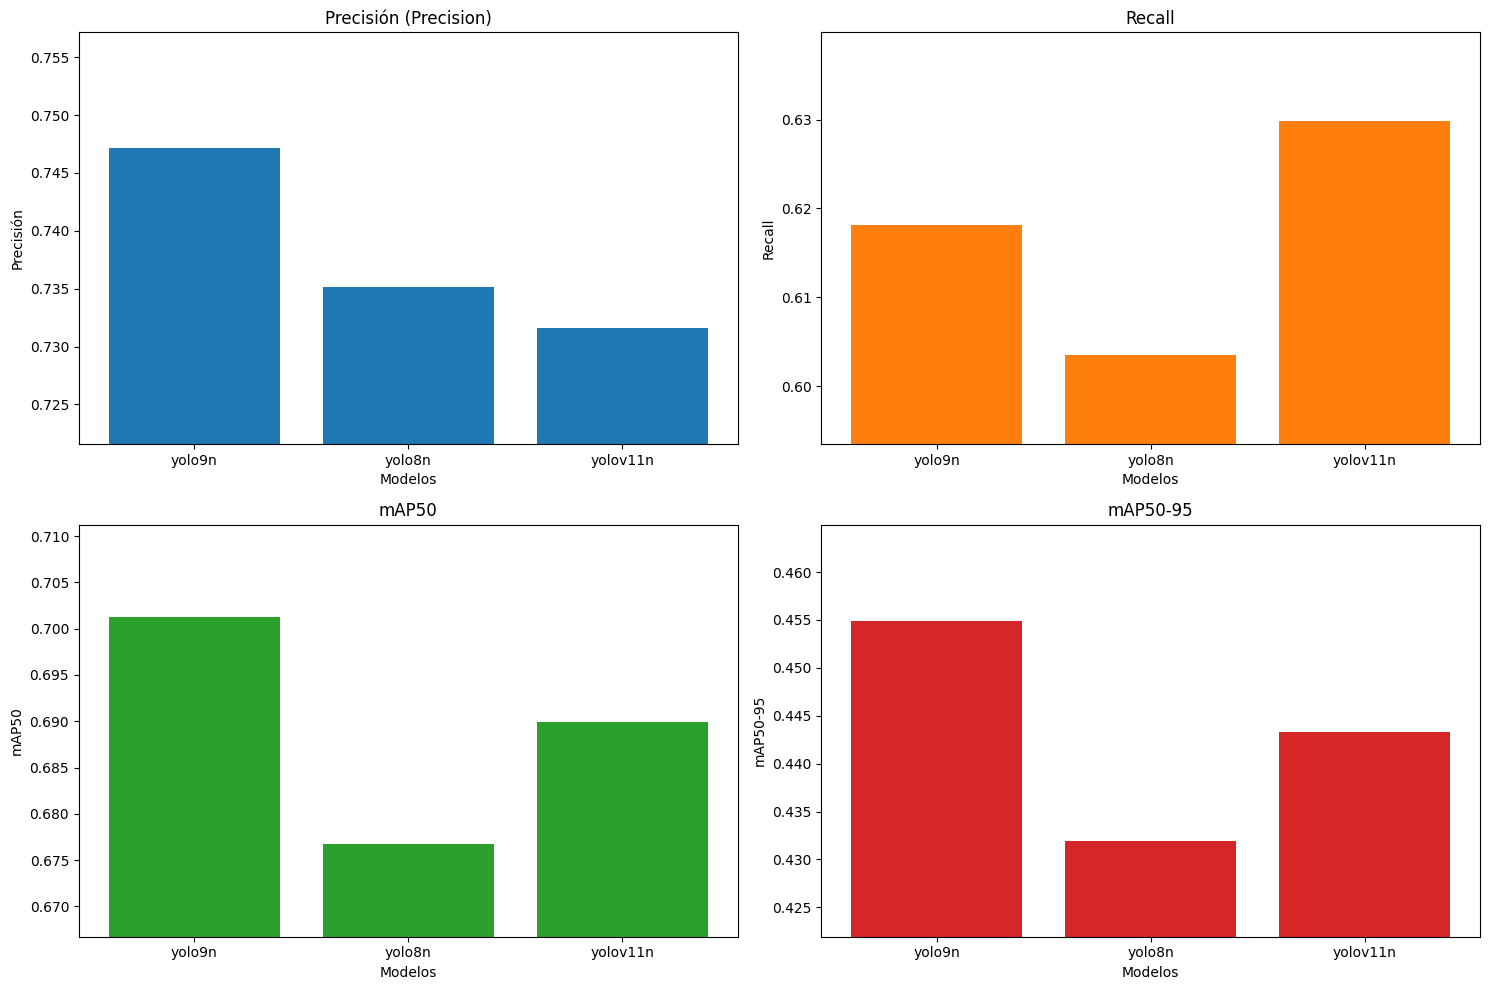

In [54]:
# A partir de los 'resultados' sacamos las grafiacas con los resultados de test

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,10))

modelos = list(resultados.keys())

precision = [resultados[modelo].results_dict['metrics/precision(B)'] for modelo in modelos]
recall = [resultados[modelo].results_dict['metrics/recall(B)'] for modelo in modelos]
mAP50 = [resultados[modelo].results_dict['metrics/mAP50(B)'] for modelo in modelos]
mAP50_95 = [resultados[modelo].results_dict['metrics/mAP50-95(B)'] for modelo in modelos]

min_precision = min(precision)
max_precision = max(precision)

min_recall = min(recall)
max_recall = max(recall)

min_mAP50 = min(mAP50)
max_mAP50 = max(mAP50)

min_mAP50_95 = min(mAP50_95)
max_mAP50_95 = max(mAP50_95)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Gráfico de precisión
axs[0, 0].bar(modelos, precision, color=colors[0])
axs[0, 0].set_title('Precisión (Precision)')
axs[0, 0].set_xlabel('Modelos')
axs[0, 0].set_ylabel('Precisión')
axs[0, 0].set_ylim(min_precision - 0.01, max_precision + 0.01)

# Gráfico de recall
axs[0, 1].bar(modelos, recall, color=colors[1])
axs[0, 1].set_title('Recall')
axs[0, 1].set_xlabel('Modelos')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].set_ylim(min_recall - 0.01, max_recall + 0.01)

# Gráfico de mAP50
axs[1, 0].bar(modelos, mAP50, color=colors[2])
axs[1, 0].set_title('mAP50')
axs[1, 0].set_xlabel('Modelos')
axs[1, 0].set_ylabel('mAP50')
axs[1, 0].set_ylim(min_mAP50 - 0.01, max_mAP50 + 0.01)

# Gráfico de mAP50-95
axs[1, 1].bar(modelos, mAP50_95, color=colors[3])
axs[1, 1].set_title('mAP50-95')
axs[1, 1].set_xlabel('Modelos')
axs[1, 1].set_ylabel('mAP50-95')
axs[1, 1].set_ylim(min_mAP50_95 - 0.01, max_mAP50_95 + 0.01)

plt.tight_layout()
plt.show()





### Verificamos con las gráficas generadas por yolo

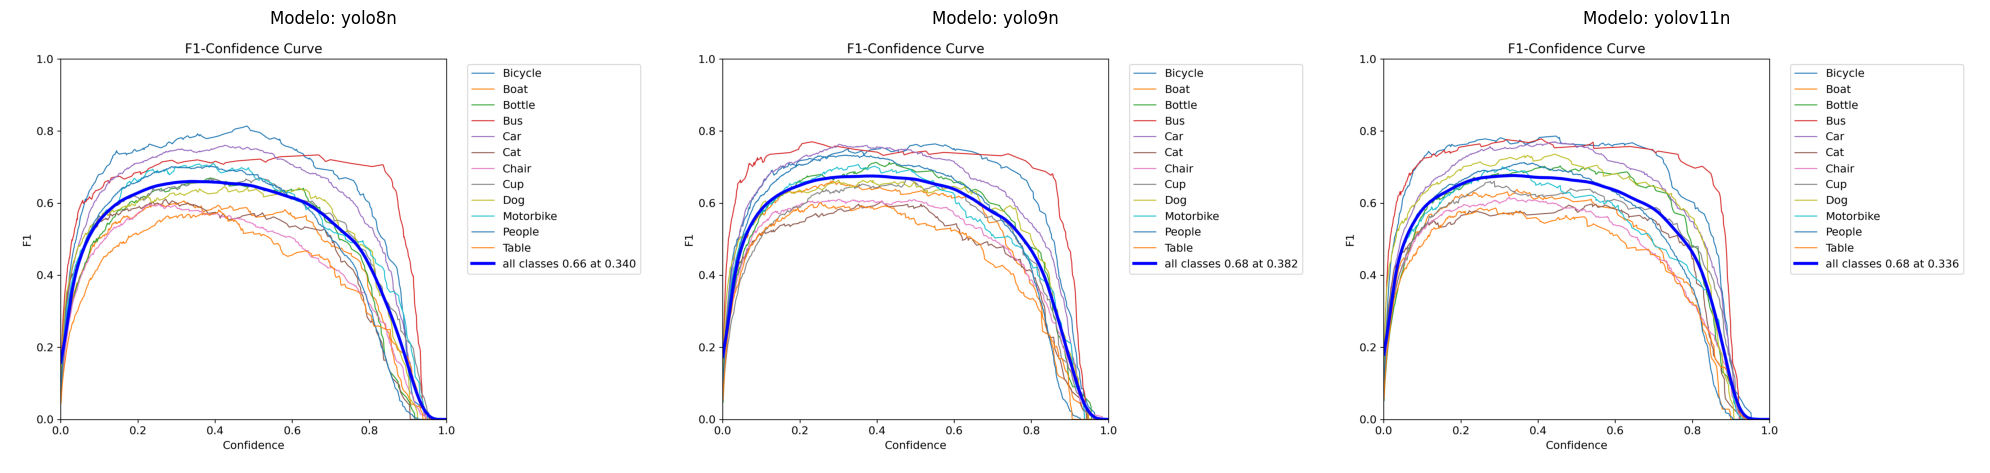

In [63]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Rutas a las imágenes F1
ruta1 = './resultados_test_200_epoc/validacionTest_yolo8n/F1_curve.png'
ruta2 = './resultados_test_200_epoc/validacionTest_yolo9n/F1_curve.png'
ruta3 = './resultados_test_200_epoc/validacionTest_yolov11n/F1_curve.png'

# Cargar las imágenes
image1 = mpimg.imread(ruta1)
image2 = mpimg.imread(ruta2)
image3 = mpimg.imread(ruta3)

# Crear una figura y ejes con mayor altura
fig, axs = plt.subplots(1, 3, figsize=(20, 10)) 

# Mostrar las imágenes en los ejes
axs[0].imshow(image1)
axs[0].set_title('Modelo: yolo8n')
axs[0].axis('off')

axs[1].imshow(image2)
axs[1].set_title('Modelo: yolo9n')
axs[1].axis('off')

axs[2].imshow(image3)
axs[2].set_title('Modelo: yolov11n')
axs[2].axis('off')

# Ajustar el layout y mostrar la figura
plt.tight_layout()
plt.savefig('./graficas resultados/F1vs.png')
plt.show()


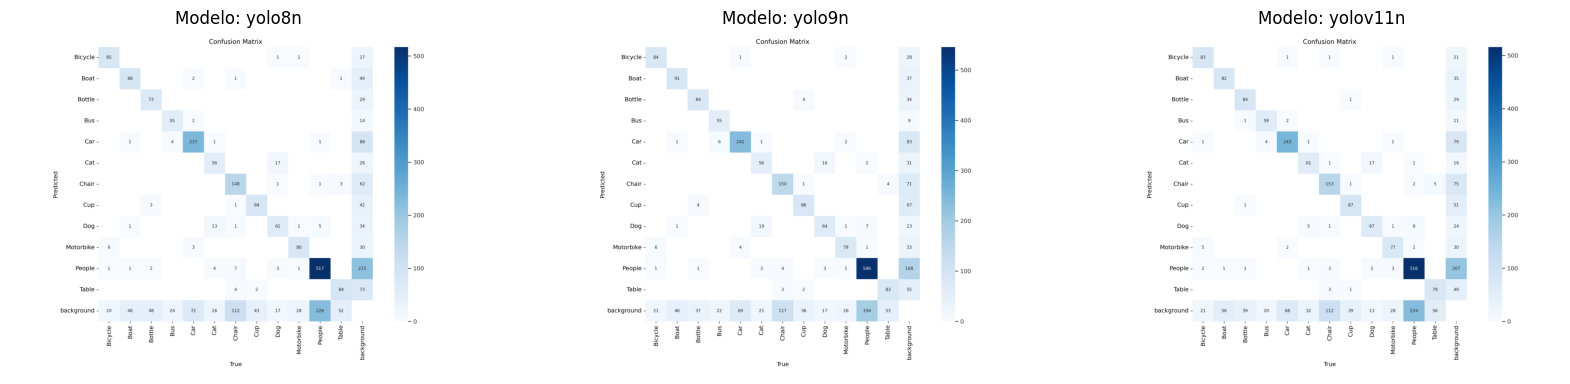

In [64]:
# Rutas a las imágenes matriz de confusión
ruta1 = './resultados_test_200_epoc/validacionTest_yolo8n/confusion_matrix.png'
ruta2 = './resultados_test_200_epoc/validacionTest_yolo9n/confusion_matrix.png'
ruta3 = './resultados_test_200_epoc/validacionTest_yolov11n/confusion_matrix.png'

# Cargar las imágenes
image1 = mpimg.imread(ruta1)
image2 = mpimg.imread(ruta2)
image3 = mpimg.imread(ruta3)

# Crear una figura y ejes con mayor altura
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Mostrar las imágenes en los ejes
axs[0].imshow(image1)
axs[0].set_title('Modelo: yolo8n')
axs[0].axis('off')

axs[1].imshow(image2)
axs[1].set_title('Modelo: yolo9n')
axs[1].axis('off')

axs[2].imshow(image3)
axs[2].set_title('Modelo: yolov11n')
axs[2].axis('off')

# Ajustar el layout y mostrar la figura
plt.savefig('./graficas resultados/Confusion_matrix_vs.png')
plt.show()
